In [148]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import spacy

from sklearn.model_selection import train_test_split

In [149]:
train = pd.read_csv('data/train.csv')
train.dropna(inplace= True)
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [150]:
test = pd.read_csv('data/test.csv')
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [151]:
train.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,32f17aee22,"Rain finally arriving, drat. Guess this means ...",good,neutral
freq,1,1,199,11117


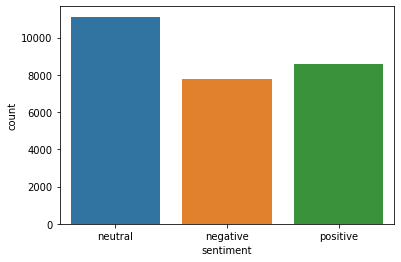

In [152]:
sns.countplot(train['sentiment'])

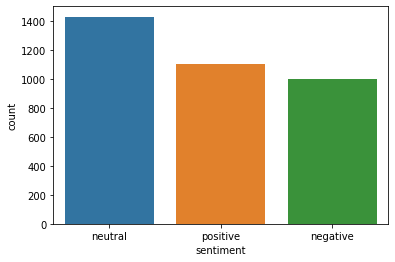

In [153]:
sns.countplot(test['sentiment'])

In [154]:
train.groupby('sentiment').count()

,textID,text,selected_text
sentiment,,,
negative,7781,7781,7781
neutral,11117,11117,11117
positive,8582,8582,8582


In [194]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [156]:
def calcJaccard(df):
    jcc_list=[]
    for row in df.itertuples():
        sub_text = row.selected_text
        text = row.text
        jcc = jaccard(text,sub_text)
        jcc_list.append(jcc)
    return sum(jcc_list)/len(jcc_list)

In [157]:
calcJaccard(pos_df)

0.3143716500527577

In [158]:
calcJaccard(neg_df)

0.33861280727421755

In [159]:
calcJaccard(neutral_df)

0.9764446695277987

In [160]:
calcJaccard(neutral_df)

0.9764446695277987

In [161]:
train['text_len']= train['text'].apply(lambda x: len(x.split(' ')))
train['select_len']= train['selected_text'].apply(lambda x: len(x.split(' ')))

In [162]:
pos_df =train[train['sentiment'] == 'positive']
neg_df =train[train['sentiment'] == 'negative']
neutral_df =train[train['sentiment'] == 'neutral']

In [163]:
pos_df.sort_values(by=['text_len','text_len'],ascending=True).head()

,textID,text,selected_text,sentiment,text_len,select_len
68,fa2654e730,Chilliin,Chilliin,positive,1,1
430,a78ef3e0d0,Goodmorning,Goodmorning,positive,1,1
1319,bc84f21e3b,ShoesShoesShoes.YayYayYay.lol.IWouldPostATwitP...,ShoesShoesShoes.YayYayYay.lol.I,positive,1,1
3882,63aedbe9fe,Goooooodmorning,Goooooodmorning,positive,1,1
6520,9fdfd84b24,Relaxing,Relaxing,positive,1,1


In [195]:
tmp_df = pos_df[pos_df['text_len']< 3]
print(len(tmp_df))
calcJaccard(tmp_df)

86


0.8546511627906976

In [196]:
tmp_df = pos_df[pos_df['text_len'] < 2]
print(len(tmp_df))
calcJaccard(tmp_df)

11


0.7272727272727273

In [197]:
tmp_df = neg_df[neg_df['text_len'] < 4]
print(len(tmp_df))
calcJaccard(tmp_df)

250


0.711

In [198]:
tmp_df = neg_df[neg_df['text_len'] < 3]
print(len(tmp_df))
calcJaccard(tmp_df)

63


0.8068783068783068

In [199]:
tmp_df = neg_df[neg_df['text_len'] < 3]
print(len(tmp_df))
calcJaccard(tmp_df)

63


0.8068783068783068

In [182]:
tmp_df = neutral_df[neutral_df['text_len'] < 3]
print(len(tmp_df))
calcJaccard(tmp_df)

267


0.9831460674157303

In [183]:
def predictSelectedText(row, model):
    text = row['text']
    selected_text = row['selected_text']
    doc = model(text)
    prediction = text
    for ent in doc.ents:
        prediction = ent.text
    jacc_score = jaccard(prediction, selected_text)
    return (prediction, jacc_score)

In [184]:
def predict_neg_pos(df, sentiment):
    X = df[['selected_text','text']]
    y = df['selected_text']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    if(sentiment == "positive"):
        model = spacy.load('positive_model')
    elif(sentiment == "negative"):
        model = spacy.load('negative_model')
    prediction_df =pd.DataFrame(columns=['text','selected_text','prediction', 'jcc'])
    prediction_df['text'] = X_test['text']
    prediction_df['selected_text'] = X_test['selected_text']
    (prediction_df['prediction'], prediction_df['jcc'])=zip(*X_test.apply(predictSelectedText,model=model, axis=1)) 
    return prediction_df

In [185]:
def predict_neutral(df):
    X = df[['selected_text','text']]
    y = df['selected_text']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    prediction_df =pd.DataFrame(columns=['selected_text','prediction', 'jcc'])
    prediction_df['selected_text'] = X_test['selected_text']
    prediction_df['prediction'] = X_test['text']
    prediction_df['jcc'] = X_test.apply(lambda x : jaccard(x['text'], x['selected_text']), axis=1 )
    return prediction_df

In [206]:
pred_neutral_df=predict_neutral(neutral_df)

In [207]:
pred_positive_df=predict_neg_pos(pos_df,"positive")

In [208]:
pred_negative_df=predict_neg_pos(neg_df,"negative")

In [209]:
sum(pred_positive_df['jcc'])/len(pred_positive_df)

0.44965089525469376

In [210]:
sum(pred_negative_df['jcc'])/len(pred_negative_df)

0.4546168420229151

In [211]:
prediction_df = pred_neutral_df.append([pred_positive_df, pred_negative_df])

In [212]:
sum(prediction_df['jcc'])/len(prediction_df)

0.6647618877841579

In [222]:
pred_positive_df= pred_positive_df.sort_values(by='jcc', ascending= True)

In [226]:
pred_positive_df[200:300]

,text,selected_text,prediction,jcc
17893,since I`m reading the Twilight series and wat...,.perfect,perfect,0.000000
4623,yo u can`t love 1 twin and not the other lol,lol,love,0.000000
9389,saw Hannah Montana Movie today!! was the best!...,was AWESOMEEEEEE!!!!!!,best!,0.000000
20415,"I usually do if there is choice, but I am luc...",most foods I love are generally very healthy,lucky,0.000000
7791,Poor kitties If there`s nothing that can be ...,a good,hopefully,0.000000
17479,Jeff & I are looking for long lasting love! Ju...,like,looking,0.000000
9660,The nocturnal serendipity... Kashmir is an imp...,serendipity..,The nocturnal serendipity... Kashmir is an imp...,0.000000
15699,: yay! it will be good to have you back,good,yay!,0.000000
19070,MORNING!!! Hope you all have a lovely holiday ...,lovely,Hope,0.000000
26771,awww i mish u too ladie whats been good?,awww i mish u too ladie whats been good?,good,0.000000


In [223]:
#jaccard('great.','great...')

In [216]:
#'great.'.split()